Useful packaeges

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np
from numpy import mean
from numpy import std

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import  GridSearchCV, KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import  GridSearchCV, KFold, train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils import resample
from sklearn import model_selection 


Load dataset

In [2]:
df = pd.read_excel(r"C:\Users\Nicola\Desktop\MASTER_BIG_DATA\Machine Learning\Consglio\5 (3)\Python\default of credit card clients.xls")
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header
df = df.drop(columns=['ID'],axis=1)
df = df.iloc[:,0:25].apply(pd.to_numeric)

Check missing values

In [3]:
marr = df.groupby(['MARRIAGE']).count()
edu = df.groupby(['EDUCATION']).count()


Text(0.5, 1.0, 'Check valori nulli variabile Marriage')

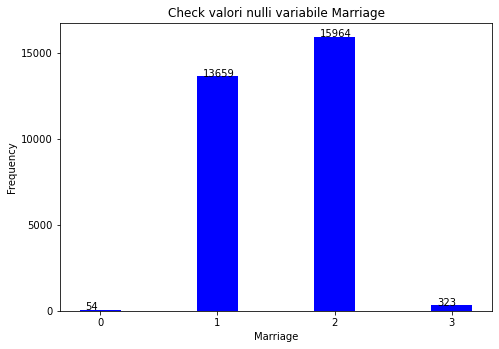

In [4]:
ind = ['0','1','2','3'] # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, marr.iloc[:,0], width, color='b')
ax.set_ylabel('Frequency')
ax.set_xlabel('Marriage')
ax.set_xticks(ind)
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.05, p.get_height()+0.01))
ax.set_yticks(np.arange(0, 20000, 5000))
plt.title('Check valori nulli variabile Marriage')
#ax.legend(labels=['Training', 'Test'],loc='upper right')


Text(0.5, 1.0, 'Check valori nulli variabile Education')

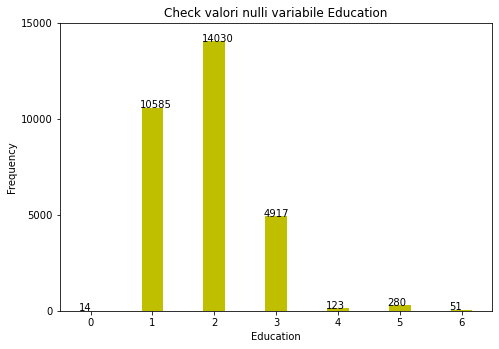

In [5]:
ind = ['0','1','2','3','4','5','6'] # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, edu.iloc[:,0], width, color='y')
ax.set_ylabel('Frequency')
ax.set_xlabel('Education')
ax.set_xticks(ind)
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()-0.02, p.get_height()+0.01))
ax.set_yticks(np.arange(0, 20000, 5000))
plt.title('Check valori nulli variabile Education')

CHECK MISSING VALUES: all'interno del dataset per le colonne education e marriage ci sono delle categorie uguali a 0 che non sono esistono della descrizione del dataset. 
considerando che sono 68 righe, decido di eliminarle pioichè non riduce dui molto la numerosità campionaria.

In [6]:
df_no_missing = df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]

CHECK BALANCE

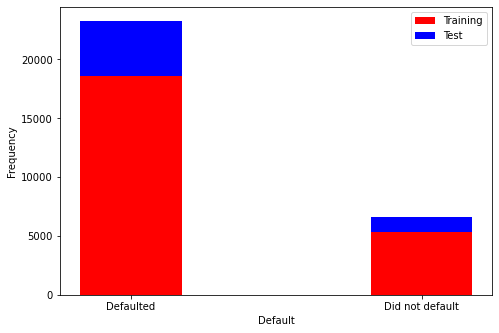

In [7]:
training_df, testing_df = model_selection.train_test_split(df_no_missing, test_size=0.2, random_state=1)
train_dim=training_df.groupby('default payment next month').count()
test_dim=testing_df.groupby('default payment next month').count()

ind = ['Defaulted','Did not default'] # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, train_dim.iloc[:,0], width, color='r')
ax.bar(ind, test_dim.iloc[:,0], width, bottom=train_dim.iloc[:,0],color='b')
ax.set_ylabel('Frequency')
ax.set_xlabel('Default')
ax.set_xticks(ind)
#ax.set_yticks(np.arange(0, 30000, 10000))
ax.legend(labels=['Training', 'Test'],loc='upper right')

fig.savefig('fig1.png', dpi = 100)

In [8]:
df_no_default = df_no_missing[df_no_missing['default payment next month']==0]
default = df_no_missing[df_no_missing['default payment next month']==1]
df_no_default_downsampled = resample(df_no_default,
                                    replace = False,
                                    n_samples=1000,
                                    random_state=42)
default_downsampled = resample(default,
                                    replace = False,
                                    n_samples=1000,
                                    random_state=42)
df_downsampled = pd.concat([df_no_default_downsampled,default_downsampled])

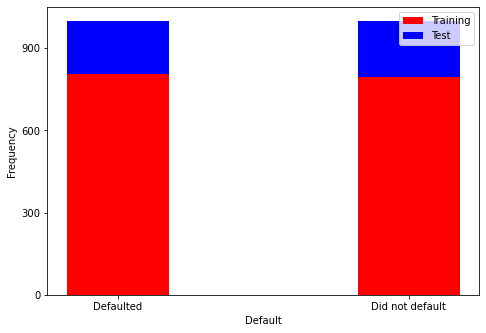

In [9]:
training_df, testing_df = model_selection.train_test_split(df_downsampled, test_size=0.2, random_state=1)
train_dim=training_df.groupby('default payment next month').count()
test_dim=testing_df.groupby('default payment next month').count()

ind = ['Defaulted','Did not default']  # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, train_dim.iloc[:,0], width, color='r')
ax.bar(ind, test_dim.iloc[:,0], width, bottom=train_dim.iloc[:,0],color='b')
ax.set_ylabel('Frequency')
ax.set_xlabel('Default')
ax.set_xticks(ind)
ax.set_yticks(np.arange(0, 1000, 300))
ax.legend(labels=['Training', 'Test'],loc='upper right')
plt.show()

Normalizing data.

In [14]:
training_df, testing_df = model_selection.train_test_split(df_downsampled, test_size=0.2, random_state=1)

In [15]:
training_df = pd.get_dummies(training_df, columns=['SEX',
                        'EDUCATION',
                        'MARRIAGE',
                        'PAY_0',
                        'PAY_2',
                        'PAY_3',
                        'PAY_4',
                        'PAY_5',
                        'PAY_6',])


In [16]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = 2*(df[feature_name] - min_value) / (max_value - min_value)-1
    return result
training_df = normalize(training_df)

Nested cross validation with linear kernel

In [17]:
X_features = np.array(training_df.drop(columns = ['default payment next month'],axis = 1).to_numpy())
y_target = np.array(training_df[['default payment next month']].to_numpy())

In [18]:
gridHyperPar = {'C':[0.5,1,10,100]}

In [19]:
outerCV = KFold(n_splits=5)

In [20]:
outerScores_1=np.array([])

In [21]:
for trainOuter, testOuter in outerCV.split(X_features):
    
    current_X_Outer_TrainingSet = X_features[trainOuter]
    
    current_X_Outer_TestSet = X_features[testOuter]
    
    current_y_Outer_TrainingSet = y_target[trainOuter]
    
    current_y_Outer_TestSet = y_target[testOuter]

    innerCV = KFold(n_splits=3, shuffle=True, random_state=1)
    svmModel = LinearSVC(random_state=0, 
                     tol=1e-5,dual=False,
                     max_iter = 5000)
    gridSearch = GridSearchCV(svmModel, 
                              gridHyperPar, 
                              scoring='accuracy', 
                              cv=innerCV, refit=True)
    searchResult = gridSearch.fit(current_X_Outer_TrainingSet,
                                  current_y_Outer_TrainingSet.ravel())
    best_model = searchResult.best_estimator_
    
    bestHyperParameter = gridSearch.best_params_['C']
    current_y_Predictions = best_model.predict(current_X_Outer_TestSet)
    currentScore = accuracy_score(current_y_Outer_TestSet, 
                                 current_y_Predictions)
    outerScores_1 = np.append(outerScores_1, currentScore)
    print('Accuracy = %.3f, Best Hyper Parameter = %.3f' % (currentScore, bestHyperParameter))

print('Accuracy = %.3f (%.3f)' % (mean(outerScores_1), std(outerScores_1))) 

Accuracy = 0.738, Best Hyper Parameter = 1.000
Accuracy = 0.666, Best Hyper Parameter = 1.000
Accuracy = 0.703, Best Hyper Parameter = 0.500
Accuracy = 0.691, Best Hyper Parameter = 0.500
Accuracy = 0.666, Best Hyper Parameter = 0.500
Accuracy = 0.693 (0.027)


SVM with linear kernel using training and test set

In [22]:
df_downsampled_def = df_downsampled
df_downsampled_def = normalize(df_downsampled_def)

In [23]:
X_features_def = np.array(df_downsampled_def.drop(columns = ['default payment next month'],axis = 1).to_numpy())
y_target_def = np.array(df_downsampled_def[['default payment next month']].to_numpy())

In [24]:
X_Train, X_Test, y_Train, y_Test = model_selection.train_test_split(X_features_def, y_target_def,test_size=0.2, random_state=1)

In [96]:
gridHyperPar = {'C':[0.5,1,10,100]}

crossValidationModel = KFold(n_splits=10)

svmModel = LinearSVC(random_state=0, 
                     tol=1e-5,dual=False,
                     max_iter = 5000)

gridSearch = GridSearchCV(svmModel, 
                          gridHyperPar, 
                          scoring='accuracy', 
                          cv=crossValidationModel, 
                          refit=True)


searchResult = gridSearch.fit(X_Train,
                              y_Train.ravel())


best_model = searchResult.best_estimator_
    
bestHyperParameter = gridSearch.best_params_['C']

y_Predictions = best_model.predict(X_Test)

score = accuracy_score(y_Test, y_Predictions)

print('\nAccuracy = %.3f, Best Hyper Parameter = %.3f\n' % (score, bestHyperParameter))


target_names = ['Did not default', 'Defaulted']

print(classification_report(y_Test, y_Predictions,
                            target_names = target_names
                            ))

#df_class_report = pandas_classification_report(y_true=y_true, y_pred=y_pred)
np.set_printoptions(precision=2)



Accuracy = 0.610, Best Hyper Parameter = 1.000

                 precision    recall  f1-score   support

Did not default       0.59      0.67      0.62       195
      Defaulted       0.64      0.56      0.59       205

       accuracy                           0.61       400
      macro avg       0.61      0.61      0.61       400
   weighted avg       0.61      0.61      0.61       400



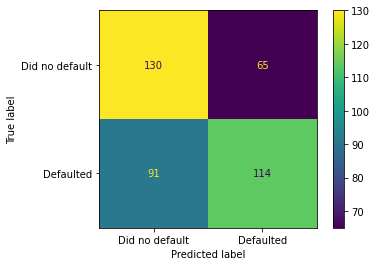

In [26]:
plot_confusion_matrix(gridSearch,
                        X_Test,
                        y_Test,
                        values_format='d',
                        display_labels = ['Did no default', 'Defaulted'])

Nested cross validation with non linear kernel

In [27]:
gridHyperPar_2 =  [
    {'C':[0.5,1,10,100],
     'gamma':[1,0.1,0.01,0.001,0.0001],
     'kernel':['rbf']},
     ]

In [28]:
outerCV_2 = KFold(n_splits=5)

In [29]:
outerScores_2=np.array([])

In [30]:
for trainOuter, testOuter in outerCV_2.split(X_features):
    current_X_Outer_TrainingSet = X_features[trainOuter]
    
    current_X_Outer_TestSet = X_features[testOuter]
    
    current_y_Outer_TrainingSet = y_target[trainOuter]
    
    current_y_Outer_TestSet = y_target[testOuter]
    
    innerCV = KFold(n_splits=3, shuffle=True, random_state=0)
    clf_svm = SVC(random_state=0, kernel = 'rbf')
    gridSearch = GridSearchCV(clf_svm, 
                              gridHyperPar_2, 
                              scoring='accuracy', 
                              cv=innerCV, refit=True)
    searchResult = gridSearch.fit(current_X_Outer_TrainingSet,
                                  current_y_Outer_TrainingSet.ravel())
    best_model = searchResult.best_estimator_
    
    bestHyperParameter_C = gridSearch.best_params_['C']
    bestHyperParameter_gamma = gridSearch.best_params_['gamma']
    current_y_Predictions = best_model.predict(current_X_Outer_TestSet)
    currentScore = accuracy_score(current_y_Outer_TestSet, 
                                 current_y_Predictions)
    outerScores_2 = np.append(outerScores_2, currentScore)
    print('Accuracy = %.3f, C = %.3f, gamma = %.4f' % (currentScore, bestHyperParameter_C, bestHyperParameter_gamma))

print('Accuracy = %.3f (%.3f)' % (mean(outerScores_2), std(outerScores_2))) 

Accuracy = 0.731, C = 1.000, gamma = 0.0100
Accuracy = 0.694, C = 1.000, gamma = 0.0100
Accuracy = 0.700, C = 10.000, gamma = 0.0100
Accuracy = 0.688, C = 0.500, gamma = 0.1000
Accuracy = 0.688, C = 0.500, gamma = 0.1000
Accuracy = 0.700 (0.016)


SVM with non linear kernel using train and test set.

In [31]:
gridHyperPar_2 =  [
    {'C':[0.5,1,10,100],
     'gamma':[1,0.1,0.01,0.001,0.0001],
     'kernel':['rbf']},
     ]
crossValidationModel = KFold(n_splits=10)

# svmModel = SVC(kernel="linear",cache_size=1000)

svmModel = SVC(random_state=0)

gridSearch = GridSearchCV(svmModel, 
                          gridHyperPar_2, 
                          scoring='accuracy', 
                          cv=crossValidationModel, 
                          refit=True)


searchResult = gridSearch.fit(X_Train,
                              y_Train.ravel())


best_model = searchResult.best_estimator_
    
bestHyperParameter_c = gridSearch.best_params_['C']
bestHyperParameter_gamma = gridSearch.best_params_['gamma']

y_Predictions = best_model.predict(X_Test)

score = accuracy_score(y_Test, y_Predictions)

print('\nAccuracy = %.3f, C = %.3f, gamma = %.3f\n' % (score, bestHyperParameter_c, bestHyperParameter_gamma))

# Plot non-normalized confusion matrix

target_names = ['Did not default', 'Defaulted']

print(classification_report(y_Test, y_Predictions,
                            target_names = target_names
                            ))


np.set_printoptions(precision=2)



Accuracy = 0.650, C = 100.000, gamma = 0.100

                 precision    recall  f1-score   support

Did not default       0.62      0.71      0.67       195
      Defaulted       0.68      0.59      0.63       205

       accuracy                           0.65       400
      macro avg       0.65      0.65      0.65       400
   weighted avg       0.65      0.65      0.65       400



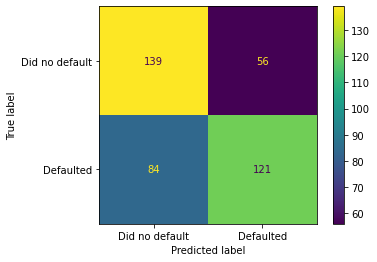

In [32]:
plot_confusion_matrix(gridSearch,
                        X_Test,
                        y_Test,
                        values_format='d',
                        display_labels = ['Did no default', 'Defaulted'])